# M6 Team Assignment: Spooky Authorship With Spark Part 2

#### Group 13
- Aidan Lonergan
- Daniel Lillard
- Radhika Garg
- Claudine Uwiragiye

## Objective
- In this assignment, your team will improve your scores from the first Spooky Authorship assignment. Your goal should be to get at least a 80% accuracy. If you already have over 80% accuracy, aim to get 85% accuracy. 

### Team Objectives
- Initially we tried to improve the accuracy of our Multilayer Perceptron Classifier, but after hours of cross validations and numerous revisions to the preprocessing, we could not surpass 72% test accuracy with that algorithm. Lemmatization did not help this model for some reason
- We decided to completely revamp the preprocessing and try to improve NaiveBayes which performed the second best originally, this proved to be much easier and tuneable when adding lemmatization.
    - Lemmatizing with POS (Part of speech) helped improve the accuracy greatly
    - Unlike the MLP, increasing the hashing tf numFeatures improved accuracy

<hr>

### Stage 0 - Import Data

In [37]:
# Stage 0 Solution
from pyspark.sql import SparkSession
import pandas as pd

# Start spark session and load train and test data sets
spark = SparkSession.builder \
    .appName("Module_5_Project") \
    .master("local[4]") \
    .config("spark.driver.memory", "20g") \
    .config("spark.executor.memory", "20g") \
    .config("spark.python.worker.memory", "1g") \
    .config("spark.executor.pyspark.memory", "2g") \
    .config("spark.rpc.io.connectionTimeout", "30s") \
    .config("spark.default.parallelism", "16") \
    .config("spark.executor.cores", "8") \
    .config("spark.task.cpus", "1") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

df_train = spark.read.csv('./train.csv', header=True, inferSchema=True, quote='"', escape='"')


<hr>

### Stage 1 - Data Preparation
- Originally we had removed punctuation, stop words, and did not do lemmatization. After redoing the preprocessing to only do lemmatization this greatly increased the accuracy
- It's possible that either identifying information was removed through the excessive preprocessing, or combining lemmatization and other steps removed information.
- Either way we decided to keep it simple and go with what performed best

In [38]:
# Step 1 - Preprocessing
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download nltk resources
nltk.download('wordnet')
nltk.download('own-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# 'Switch' function for returing the POS tag
def pos_switch(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Lemmatizes the input text with POS (Part of speech)
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize words
    words = word_tokenize(text)
    
    # Get POS tag for tokens
    tags = pos_tag(words)

    # Lemmatize based on token and tag
    lemmatized_text = [lemmatizer.lemmatize(word, pos_switch(pos)) for word, pos in tags]
    return " ".join(lemmatized_text)

# Convert to Pandas DataFrame temporarily. Had immense issues with PySpark UDFs and worker timeouts. This just makes it simple
df_tmp = df_train.toPandas()

# Lemmatize text into new column
df_tmp["processed_text"] = df_tmp["text"].apply(lemmatize_text)

# Convert back to Spark DataFrame
df_lemmatized = spark.createDataFrame(df_tmp) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acct_pers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading own-1.4: Package 'own-1.4' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acct_pers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\acct_pers\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<hr>

### Stage 2 - Feature Extraction

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Define stages for pipeline [Tokenization -> TF -> IDF]
tokenizer = Tokenizer(inputCol="processed_text", outputCol="tokens")            # Converts the pos lemmatized text into tokens
hashingTF = HashingTF(inputCol='tokens', outputCol='tf', numFeatures=524288)    # Computes a hashing TF on the tokens. 524288 has the highest accuracy, going higher reduced it
idf = IDF(inputCol='tf', outputCol='features', minDocFreq=3)                    # Computes an IDF on the hashing TF output


# Define pipeline with all stages
nb_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

# Execute the pipeline with the pos lemmatized text and transform to tfidf
tfidf = nb_pipeline.fit(df_lemmatized).transform(df_lemmatized)
tfidf.select("features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                    

<hr>

### Stage 3 - Machine Learning
1) Perform 80/20 train/test split
2) Train Naive Bayes to achieve >80% accuracy

In [49]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Convert authors to numerical labels
indexer = StringIndexer(inputCol="author", outputCol="label")
# had to break these steps out to grab the indicies.
indexer_model = indexer.fit(tfidf)
df_labeled = indexer_model.transform(tfidf)

# Do a 80/20 split for validations
df_train, df_test = df_labeled.randomSplit([0.8, 0.2], seed=42)

# Setup model and evaluators
naive_bayes = NaiveBayes()
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Setup hyper param to test, here we're just adjusting the smoothing for NB
params = ParamGridBuilder().addGrid(
    naive_bayes.smoothing, [0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5]
    ).build()

# Set cross validator params
cv = CrossValidator(
    estimator=naive_bayes, 
    estimatorParamMaps=params, 
    evaluator=accuracy_evaluator, 
    parallelism=8
    )

# Train the cross validator to find the best model
model = cv.fit(df_train)
best_model = model.bestModel

# Predict on the test set
nb_prediction = best_model.transform(df_test)

# Evaluate 
print('Test Accuracy:', accuracy_evaluator.evaluate(nb_prediction))
print('Test F1 Score:', f1_evaluator.evaluate(nb_prediction))
print(f'Best smoothing parameter: {best_model.getSmoothing()}')

Test Accuracy: 0.8351962568234989
Test F1 Score: 0.8352423061400291
Best smoothing parameter: 1.1


<hr>

### Stage 4 - Evaluation and Visualization

Naive Bayes Accuracy Score: 0.8352423061400291


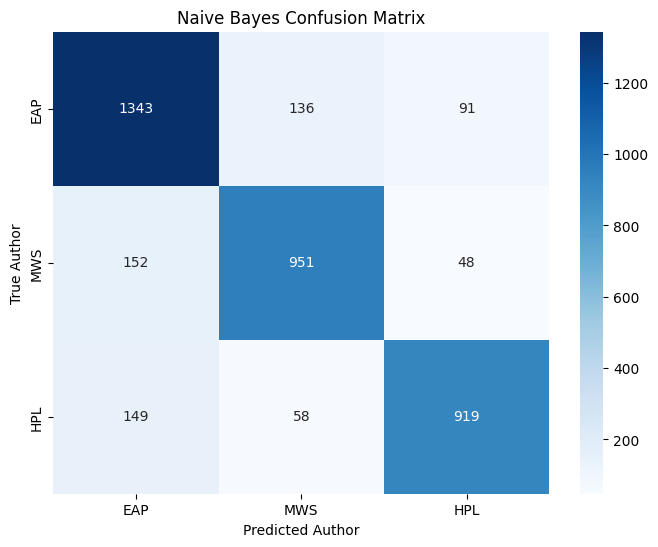

In [74]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, lit

nb_test_predictions = best_model.transform(df_test)

nb_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
acc_score = nb_evaluator.evaluate(nb_test_predictions)
print(f"Naive Bayes Accuracy Score: {acc_score}")

label_mapping = indexer_model.labels

nb_test_predictions = nb_test_predictions.withColumn(
    "predicted_author",
    col("prediction").cast("int").cast("string")
).replace(
    to_replace={str(i): label for i, label in enumerate(label_mapping)},
    subset=["predicted_author"]
)

# Create confusion matrix
nb_test_predictions_pd = nb_test_predictions.select('predicted_author', 'author').toPandas()
nb_conf_mat = confusion_matrix(
    nb_test_predictions_pd['author'],
    nb_test_predictions_pd['predicted_author'],
    labels=label_mapping
)

# Wrap in DataFrame with labels
conf_df = pd.DataFrame(nb_conf_mat, index=label_mapping, columns=label_mapping)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.show()